In [1]:
import numpy as np
import matplotlib
import velGrid_old
import velGrid
from matplotlib.patches import Circle, Wedge, Polygon, Rectangle
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline

import matplotlib.colors as mcolors


def make_colormap(seq):
    """Return a LinearSegmentedColormap
    seq: a sequence of floats and RGB-tuples. The floats should be increasing
    and in the interval (0,1).
    """
    seq = [(None,) * 3, 0.0] + list(seq) + [1.0, (None,) * 3]
    cdict = {'red': [], 'green': [], 'blue': []}
    for i, item in enumerate(seq):
        if isinstance(item, float):
            r1, g1, b1 = seq[i - 1]
            r2, g2, b2 = seq[i + 1]
            cdict['red'].append([item, r1, r2])
            cdict['green'].append([item, g1, g2])
            cdict['blue'].append([item, b1, b2])
    return mcolors.LinearSegmentedColormap('CustomMap', cdict)


twopi = np.pi*2.
# cmap = "inferno"

In [ ]:
reload(velGrid)

In [2]:
long2km = 1/0.011741652782473
lat2km = 1/0.008994627867046

# Fifth ring
# xmin = 116.1904 * long2km
# xmax = 116.583642 * long2km
# ymin = 39.758029 * lat2km
# ymax = 40.04453 * lat2km
# dxCell, dyCell = 1., 1. #in km

# Second ring
xmin = 116.33085226800 * long2km
xmax = 116.44826879600 * long2km
ymin = 39.85573366870 * lat2km
ymax = 39.96366920310 * lat2km
dxCell, dyCell = 1.0,1.0 #in km

# Recalc xmax so it's naice
xmax = ((xmax-xmin)//dxCell)*dxCell + xmin
ymax = ((ymax-ymin)//dyCell)*dyCell + ymin

# Let's use a smaller region
# xmax = xmin+10*dxCell
# ymax = ymin+10*dyCell

# fname = "vmin"+str(vmin)+"_nmin"+str(nmin)
fname = "/home/michael/msc/summer17/traffic/states/"
fname2 = "/home/michael/msc/summer17/traffic/preds/t0.5v1.0n10s2r10l10e0.0001sz256_pred"
run = "secondring"
vmin = 0.
nmin = 5
tggroup = "tg_15"
tglen = 20
nTG = 60*24//tglen

xCntrs = np.arange(xmin,xmax,dxCell) + 0.5*dxCell
yCntrs = np.arange(ymin,ymax,dyCell) + 0.5*dyCell
Nx = len(xCntrs)
Ny = len(yCntrs)

tag1 = "known"
tag2 = "pred"

statepath = "/home/michael/msc/summer17/traffic/states/"
statepath2 = "/home/michael/msc/summer17/traffic/preds/"
diffdir = "/home/michael/msc/summer17/traffic/"

# statepath = "/home/michael/msc/summer17/traffic/data/"+tggroup+"/states/"+run+"/"+fname+"/"
# statepath2 = "/home/michael/msc/summer17/traffic/data/"+tggroup+"/states/"+run+"/"+fname+"/predictions/"
# diffdir = "/home/michael/msc/summer17/traffic/data/"+tggroup+"/states/"+run+"/"+fname+"/diffs/"

In [3]:
nTG

72

In [5]:
# Since the main run files are fifth ring
# Fifth ring
xmin5 = 116.1904 * long2km
xmax5 = 116.583642 * long2km
ymin5 = 39.758029 * lat2km
ymax5 = 40.04453 * lat2km

Nxmin,Nxmax = int((xmin-xmin5)//dxCell), int((xmax-xmin5)//dxCell)
Nymin,Nymax = int((ymin-ymin5)//dyCell), int((ymax-ymin5)//dyCell)

In [6]:
print Nxmin,Nxmax
print Nymin,Nymax

11 21
10 21


In [19]:
# Depends on tglen so...
def plotmap(axis,states,xcntrs,ycntrs,d,tg):
    w = xcntrs[1] - xcntrs[0]
    for xi in range(len(xcntrs)):
        for yi in range(len(ycntrs)):
            x,y = xcntrs[xi],ycntrs[yi]
            plotroadcell(axis,[x,y],w,states[xi][yi])
            
    days = {0:"Mon",
            1:"Tue",
            2:"Wed",
            3:"Thu",
            4:"Fri",
            5:"Sat",
            6:"Sun"}
    tgperhr = 60//tglen
    hr = str(tg//tgperhr)
    m = str((tg%tgperhr)*tglen)
    if m=="0": m="00"
    title = run+" | "+tggroup+" | "+fname+"\n"+days[d]+" "+hr+":"+m
    fsize = 16+(len(xcntrs)//2)
    axis.set_title(title,fontsize=fsize)
    
def diffmap(axis,states_old,states_new,xcntrs,ycntrs,d,tg,ui,tag_old,tag_new,cols):
    # states are ndarrays that used to be nested lists
    # d and tg are lists [d_old,d_new],[tg_old,tg_new]
    # ui is which state to be shown
    a1, a2 = states_old, states_new
    statediff = (a2 - a1)
    
    w = xcntrs[1] - xcntrs[0]
    for xi in range(len(xcntrs)):
        for yi in range(len(ycntrs)):
            x,y = xcntrs[xi],ycntrs[yi]
            plotdiffroadcell(axis,[x,y],w,statediff[xi,yi,d[1],tg[1],:,ui],cols)

    
    days = {0:"Mon",
            1:"Tue",
            2:"Wed",
            3:"Thu",
            4:"Fri",
            5:"Sat",
            6:"Sun"}
    tgperhr = 60//tglen
    hr1 = str(tg[0]//tgperhr)
    hr2 = str(tg[1]//tgperhr)
    m1 = str((tg[0]%tgperhr)*tglen)
    m2 = str((tg[1]%tgperhr)*tglen)
    if m1=="0": m1="00"
    if m2=="0": m2="00"
    title = "state "+str(ui)+" | "+tag_old+" "+days[d[0]]+" "+hr1+":"+m1+\
        " -> "+tag_new+" "+days[d[1]]+" "+hr2+":"+m2 
    fsize = 16+(len(xcntrs)//2)
    axis.set_title(title,fontsize=fsize)

In [64]:
def read_states(fname,D,TG,order=None):
    # states[x][y][d][tg][th] -- old
    # states[x][y][th] -- new
    #
    # Need to modify to read only specific day and tg
    #
    # source file should be day,tg,x,y,th
    #
    states = [[[[] for th in range(8)] for y in range(Ny)] \
                        for x in range(Nx)]
    fin = open(fname,'r')
    # Use end of first line to count states
    nstate = 0
    spt = fin.readline().split()
    for st in spt[5:]:
        nstate+=1
    fin.seek(0) # return back to top
    npertg = 0
    for l in fin.readlines():
        spt = l.split()
        tg = int(spt[1])
        if tg < 1:
            npertg+=1
        else: break
    fin.seek(0)

    # Skip along until proper day and tg
    nskip = D * (nTG*npertg) + TG*npertg
    iskip = 0
    
    for l in fin.readlines():
        if iskip < nskip:
            iskip+=1
            continue
        spt = l.split()
        d,tg,x,y,th = int(spt[0]),int(spt[1]),int(spt[2]),int(spt[3]),int(spt[4])
        if (x in range(Nxmin,Nxmax)) and (y in range(Nymin,Nymax)):
            state = []
            for s in spt[5:]:
                state.append(float(s))
            if order:
                state = [state[i] for i in order]
            try:
                states[x-Nxmin][y-Nymin][th]=state
            except:
                print x,y,d,tg,th,state,Nxmin,Nymin
                
        # Don't need to keep going
        if (x>Nxmax) and (y>Nymax):
            break
    fin.close()
        

    # Sweep over states and make them [-1,-1] if empty
#     for x in range(Nx):
#         for y in range(Ny):
#             for d in range(7):
#                 for tg in range(nTG):
#                     for th in range(8):
#                         if not states[x][y][d][tg][th]:
#                             s = [0 for _ in range(nstate)]
#                             states[x][y][d][tg][th] = s

    return states

In [9]:
fname

'/home/michael/msc/summer17/traffic/states/t2.0v0.n5s2r5l20_states'

In [15]:
states = read_states(fname,0,0,order=[0,1])
states2 = read_states(fname2,0,0,order=[0,1])

In [17]:
states[0][0]

[[0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0490898341564, 0.950910165844],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0508517360074, 0.949148263993]]

In [ ]:
grid = velGrid_old.velgrid([xmin,xmax,ymin,ymax],dxCell,dyCell,statepath=statepath,nTG=nTG)
# grid form is [x][y][d][tg][th]

grid.read_states([1,0])
states = np.asarray(grid.states)

In [ ]:
ranges, dxCell, dyCell, runpath, runname, nTG, tcutoff, minvel, nmin, nstate, reduceddim
grid2 = velGrid.velgrid([xmin,xmax,ymin,ymax],dxCell,dyCell,statepath=statepath2,,nTG=nTG)
grid2.read_states([1,0])
states2 = np.asarray(grid2.states)

In [ ]:
# Select day and time to look at
ds = [0]
tgs = np.arange(10)
tgs = [i for i in range(60,71)]
tfsize = 12+(Nx//2)

f, ax = plt.subplots(1,1,figsize=(2*Nx,2*Ny))

path = statepath2
stat = states2

for d in ds:
    for tg in tgs:
        ax.set_ylim(ymin,ymax)
        ax.set_xlim(xmin,xmax)
        ax.set_aspect('equal', adjustable='box')
        ax.set_xticks(xCntrs)
        ax.set_yticks(yCntrs)
        plt.setp(ax.get_xticklabels(), fontsize=tfsize)
        plt.setp(ax.get_yticklabels(), fontsize=tfsize)
        plotmap(ax,stat,xCntrs,yCntrs,d,tg)
        f.savefig(path+"/imgs/d"+str(d)+"tg"+str(tg)+".png")
        ax.cla()
f.clf()
print "Done"

In [ ]:
# Look at differences between two dtg
# grid form is [x][y][d][tg][th]
d1, d2 = 0, 0
tfsize = 12+(Nx//2)
ui = 0
cols = [(1,0,0),(0,0.6,0.4)]
clim = [[-1.,1.],[0.,1.]]
rvb = make_colormap([cols[0],(0,0,0),0.5,(0,0,0),cols[1]])

for tg1 in range(30):
    tg2 = tg1
    f, ax = plt.subplots(1,1,figsize=(2*Nx,2*Ny))
    diffmap(ax,states,states2,xCntrs,yCntrs,[d1,d2],[tg1,tg2],ui,tag1,tag2,cols)

    ax.set_ylim(ymin,ymax)
    ax.set_xlim(xmin,xmax)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xticks(xCntrs)
    ax.set_yticks(yCntrs)
    plt.setp(ax.get_xticklabels(), fontsize=tfsize)
    plt.setp(ax.get_yticklabels(), fontsize=tfsize)
    im = plt.imshow(clim,cmap=rvb)
    f.subplots_adjust(right=0.8)
    cbar_ax = f.add_axes([0.82, 0.6, 0.02, 0.24])
    f.colorbar(im, cax=cbar_ax,orientation='vertical')

    f.savefig(diffdir+"/"+tag1+"_"+tag2+"_s"+str(ui)+"_d"+str(d2)+"tg"+str(tg2)+".png")
    plt.close()
    
print "Done"

8184 261888
0 0


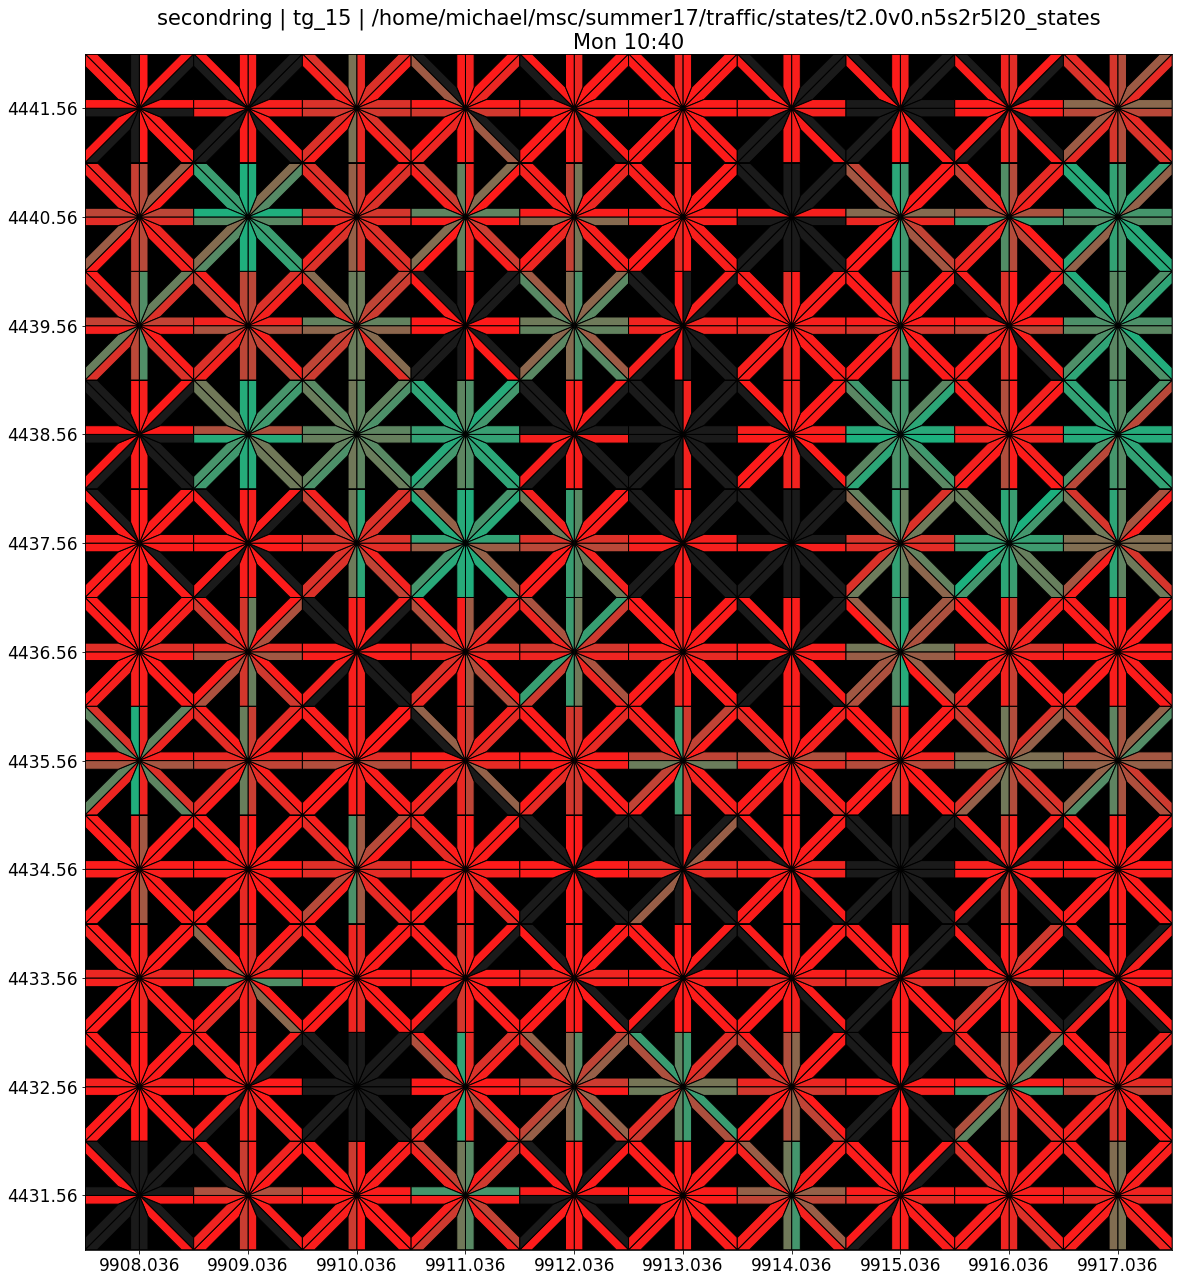

In [63]:
# Select day and time to look at
# grid form is [x][y][th]
d = 0
tg = 32
states = read_states(fname,d,tg,order=[0,1])
states2 = read_states(fname2,d,tg,order=[0,1])

tfsize = 12+(Nx//2)

f, ax = plt.subplots(1,1,figsize=(2*Nx,2*Ny))
ax.set_ylim(ymin,ymax)
ax.set_xlim(xmin,xmax)
ax.set_aspect('equal', adjustable='box')
ax.set_xticks(xCntrs)
ax.set_yticks(yCntrs)
plt.setp(ax.get_xticklabels(), fontsize=tfsize)
plt.setp(ax.get_yticklabels(), fontsize=tfsize)

plotmap(ax,states,xCntrs,yCntrs,d,tg)

clim = [[0.,1.],[0.,1.]]
# rvb = make_colormap([(0,0.6,0.4),(1,0,0)])
# im = plt.imshow(clim,cmap=rvb)
# # plt.colorbar()
# f.subplots_adjust(right=0.8)
# cbar_ax = f.add_axes([0.82, 0.6, 0.02, 0.24])
# f.colorbar(im, cax=cbar_ax,orientation='vertical')


In [46]:
def plotdiffroadcell(axis,cntr,w,u,cols):
    # w is full width of cell
    # u is c value diff for each slice
    # cntr is center of cell
    cx, cy = cntr[0],cntr[1]
    w2 = w*0.5
    rw = w*0.08 # roadwidth
    colors = []
    for c in u:
        if c>0:
            col = tuple([c1*c for c1 in cols[1]])
            colors.append(col)
        else:
            col = tuple([-c*c0 for c0 in cols[0]])
            colors.append(col)

    ecol = 'k'
    
    # First color the background
    back = Rectangle((cx-w2,cy-w2),w,w,facecolor='w',edgecolor=ecol)
#     back = Rectangle((cx-w2,cy-w2),w,w,facecolor=(0,0.6,0.4),edgecolor=ecol)
    axis.add_patch(back)
    
    thetas = [twopi * i / 8. for i in range(8)]
    
    
    l2 = rw*np.sin(twopi/16.)
    l3 = rw/np.tan(twopi/16.)
    rightroads = [
        [[cx,cy],[cx+l3,cy-rw],[cx+w2,cy-rw],[cx+w2,cy]],
        [[cx,cy],[cx+rw,cy+l3],[cx+rw,cy+w2],[cx,cy+w2]],
        [[cx,cy],[cx-l3,cy+rw],[cx-w2,cy+rw],[cx-w2,cy]],
        [[cx,cy],[cx-rw,cy-l3],[cx-rw,cy-w2],[cx,cy-w2]],
    ]
    rightroads2 = [
        [[cx,cy],[cx-l3,cy-rw],[cx-w2,cy-rw],[cx-w2,cy]],
        [[cx,cy],[cx+rw,cy-l3],[cx+rw,cy-w2],[cx,cy-w2]],
        [[cx,cy],[cx+l3,cy+rw],[cx+w2,cy+rw],[cx+w2,cy]],
        [[cx,cy],[cx-rw,cy+l3],[cx-rw,cy+w2],[cx,cy+w2]],
    ]
    
    l1 = np.sqrt(2)*rw
    diagroads = [
        [[cx,cy],[cx+l3,cy+rw],[cx+w2,cy+w2-l1],[cx+w2,cy+w2]],
        [[cx,cy],[cx-rw,cy+l3],[cx-w2+l1,cy+w2],[cx-w2,cy+w2]],
        [[cx,cy],[cx-l3,cy-rw],[cx-w2,cy-w2+l1],[cx-w2,cy-w2]],
        [[cx,cy],[cx+rw,cy-l3],[cx+w2-l1,cy-w2],[cx+w2,cy-w2]],
    ]
    # 0 is refl of 1 about x
    # 1 is refl of 2 about y
    # 2 is refl of 3 about x
    # 3 is refl of 0 about y
    diagroads2 = [
        [[cx,cy],[cx-rw,cy-l3],[cx-w2+l1,cy-w2],[cx-w2,cy-w2]],
        [[cx,cy],[cx+l3,cy-rw],[cx+w2,cy-w2+l1],[cx+w2,cy-w2]],
        [[cx,cy],[cx+rw,cy+l3],[cx+w2-l1,cy+w2],[cx+w2,cy+w2]],
        [[cx,cy],[cx-l3,cy+rw],[cx-w2,cy+w2-l1],[cx-w2,cy+w2]],
    ]
    
    for i in range(4):
        # corner wedges
        ii = i*2
        poly = Polygon(np.asarray(diagroads[i]), True, facecolor=colors[ii+1],edgecolor=ecol)
        axis.add_patch(poly)
        poly = Polygon(np.asarray(diagroads2[i]), True, facecolor=colors[ii+1],edgecolor=ecol)
        axis.add_patch(poly)
    for i in [0,2,4,6]:
        # flat wedges
        ii = i/2
        poly = Polygon(np.asarray(rightroads[ii]), True, facecolor=colors[i],edgecolor=ecol)
        axis.add_patch(poly)
        poly = Polygon(np.asarray(rightroads2[ii]), True, facecolor=colors[i],edgecolor=ecol)
        axis.add_patch(poly)


In [61]:
def plotroadcell(axis,cntr,w,u):
    # w is full width of cell
    # u is list of c values for each slice
    # cntr is center of cell
    cx, cy = cntr[0],cntr[1]
    w2 = w*0.5
    rw = w*0.08 # roadwidth
    if len(u[0]) == 2:
        colors = [(0.1 + 0.9*c[1],0.1+0.6*c[0],0.1+0.4*c[0],1.) for c in u]
    if len(u[0]) == 3:
        colors = [(c[1],c[0],0,0.8) for c in u]

    ecol = 'k'
    
    # First color the background
#     back = Rectangle((cx-w2,cy-w2),w,w,facecolor=(0,0.6,0.4),edgecolor=ecol)
    back = Rectangle((cx-w2,cy-w2),w,w,facecolor='k',edgecolor=ecol)
    axis.add_patch(back)
    
    thetas = [twopi * i / 8. for i in range(8)]
    
    
    l2 = rw*np.sin(twopi/16.)
    l3 = rw/np.tan(twopi/16.)
    rightroads = [
        [[cx,cy],[cx+l3,cy-rw],[cx+w2,cy-rw],[cx+w2,cy]],
        [[cx,cy],[cx+rw,cy+l3],[cx+rw,cy+w2],[cx,cy+w2]],
        [[cx,cy],[cx-l3,cy+rw],[cx-w2,cy+rw],[cx-w2,cy]],
        [[cx,cy],[cx-rw,cy-l3],[cx-rw,cy-w2],[cx,cy-w2]],
    ]
    rightroads2 = [
        [[cx,cy],[cx-l3,cy-rw],[cx-w2,cy-rw],[cx-w2,cy]],
        [[cx,cy],[cx+rw,cy-l3],[cx+rw,cy-w2],[cx,cy-w2]],
        [[cx,cy],[cx+l3,cy+rw],[cx+w2,cy+rw],[cx+w2,cy]],
        [[cx,cy],[cx-rw,cy+l3],[cx-rw,cy+w2],[cx,cy+w2]],
    ]
    
    l1 = np.sqrt(2)*rw
    diagroads = [
        [[cx,cy],[cx+l3,cy+rw],[cx+w2,cy+w2-l1],[cx+w2,cy+w2]],
        [[cx,cy],[cx-rw,cy+l3],[cx-w2+l1,cy+w2],[cx-w2,cy+w2]],
        [[cx,cy],[cx-l3,cy-rw],[cx-w2,cy-w2+l1],[cx-w2,cy-w2]],
        [[cx,cy],[cx+rw,cy-l3],[cx+w2-l1,cy-w2],[cx+w2,cy-w2]],
    ]
    # 0 is refl of 1 about x
    # 1 is refl of 2 about y
    # 2 is refl of 3 about x
    # 3 is refl of 0 about y
    diagroads2 = [
        [[cx,cy],[cx-rw,cy-l3],[cx-w2+l1,cy-w2],[cx-w2,cy-w2]],
        [[cx,cy],[cx+l3,cy-rw],[cx+w2,cy-w2+l1],[cx+w2,cy-w2]],
        [[cx,cy],[cx+rw,cy+l3],[cx+w2-l1,cy+w2],[cx+w2,cy+w2]],
        [[cx,cy],[cx-l3,cy+rw],[cx-w2,cy+w2-l1],[cx-w2,cy+w2]],
    ]
    
    for i in range(4):
        # corner wedges
        ii = i*2
        poly = Polygon(np.asarray(diagroads[i]), True, facecolor=colors[ii+1],edgecolor=ecol)
        axis.add_patch(poly)
        poly = Polygon(np.asarray(diagroads2[i]), True, facecolor=colors[ii+1],edgecolor=ecol)
        axis.add_patch(poly)
    for i in [0,2,4,6]:
        # flat wedges
        ii = i/2
        poly = Polygon(np.asarray(rightroads[ii]), True, facecolor=colors[i],edgecolor=ecol)
        axis.add_patch(poly)
        poly = Polygon(np.asarray(rightroads2[ii]), True, facecolor=colors[i],edgecolor=ecol)
        axis.add_patch(poly)
        